<a href="https://colab.research.google.com/github/Rebexcode/Heart-Attack-Prediction-for-Hypertensive-Patients/blob/main/Heart_Attack_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
import joblib
from sklearn.svm import SVC

# Loading the Heart Attack Dataset

In [46]:
df = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')

column_names = {
    'age': 'Age',
    'sex': 'Sex',
    'chest pain type': 'ChestPainType',
    'resting bp s': 'RestingBP',
    'cholesterol': 'Cholesterol',
    'fasting blood sugar': 'FastingBS',
    'resting ecg': 'RestingECG',
    'max heart rate': 'MaxHeartRate',
    'exercise angina': 'ExerciseAngina',
    'oldpeak': 'STDepression',
    'ST slope': 'STSlope',
    'target': 'Target'
}

# Checking if columns need renaming

In [47]:
existing_columns = set(df.columns)
columns_to_rename = {old: new for old, new in column_names.items() if old in existing_columns}
if columns_to_rename:
    df.rename(columns=columns_to_rename, inplace=True)

# Displaying Data Information

In [48]:
print("Dataset Information:")
print(f"Number of samples: {len(df)}")
print(f"Target distribution: {df['Target'].value_counts(normalize=True).to_dict()}")

Dataset Information:
Number of samples: 1190
Target distribution: {1: 0.5285714285714286, 0: 0.4714285714285714}


In [49]:
df = df[df['RestingBP'] >= 140]

# Displaying The New Data Information

In [50]:
df.value_counts()
df.shape

(416, 12)

# Defining target


In [51]:
X = df.drop('Target', axis=1)
y = df['Target']
df.Target.head(10)

,Target
0,0
1,1
4,0
8,1
13,1
23,1
30,1
34,0
36,1
39,0


# Check for missing values in the dataset

In [52]:
print("Missing Values Analysis:")
print("=" * 40)
missing_summary = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_summary.index,
    'Missing_Count': missing_summary.values,
    'Missing_Percentage': missing_percentage.values
})

print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("✓ No missing values found in the dataset")
else:
    print(f"Total missing values: {missing_df['Missing_Count'].sum()}")

print("\nDataset shape:", df.shape)
print("=" * 40)

Missing Values Analysis:
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []
✓ No missing values found in the dataset

Dataset shape: (416, 12)


# Prepare Features


In [53]:
if 'Sex' in X.columns:
    X['Sex'] = X['Sex'].astype(int)

if 'ChestPainType' in X.columns:
    X = pd.get_dummies(X, columns=['ChestPainType'], prefix='ChestPain')

if 'RestingECG' in X.columns:
    X = pd.get_dummies(X, columns=['RestingECG'], prefix='ECG')

if 'STSlope' in X.columns:
    X = pd.get_dummies(X, columns=['STSlope'], prefix='STSlope')

X['Age_MaxHR'] = X['Age'] * X['MaxHeartRate'] / 100
X['BP_Chol'] = X['RestingBP'] * X['Cholesterol'] / 1000

X['MaxHR_by_Age'] = X['MaxHeartRate'] / X['Age']

if 'ExerciseAngina' in X.columns:
    X['Angina_STDepression'] = X['ExerciseAngina'] * X['STDepression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

numerical_features = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train_resampled_scaled = X_train_resampled.copy()
X_train_resampled_scaled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features])

X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

for col in X_train_resampled.columns:
    if col not in numerical_features:
        X_train_resampled_scaled[col] = X_train_resampled[col]
        X_test_scaled[col] = X_test[col]

feature_list = X_train.columns


In [54]:
X.head(20)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHeartRate,ExerciseAngina,STDepression,ChestPain_1,ChestPain_2,ChestPain_3,ChestPain_4,ECG_0,ECG_1,ECG_2,STSlope_0,STSlope_1,STSlope_2,STSlope_3,Age_MaxHR,BP_Chol,MaxHR_by_Age,Angina_STDepression
0,40,1,140,289,0,172,0,0.0,False,True,False,False,True,False,False,False,True,False,False,68.80,40.46,4.300000,0.0
1,49,0,160,180,0,156,0,1.0,False,False,True,False,True,False,False,False,False,True,False,76.44,28.80,3.183673,0.0
4,54,1,150,195,0,122,0,0.0,False,False,True,False,True,False,False,False,True,False,False,65.88,29.25,2.259259,0.0
8,37,1,140,207,0,130,1,1.5,False,False,False,True,True,False,False,False,False,True,False,48.10,28.98,3.513514,1.5
13,49,1,140,234,0,140,1,1.0,False,False,False,True,True,False,False,False,False,True,False,68.60,32.76,2.857143,1.0
23,44,1,150,288,0,150,1,3.0,False,True,False,False,True,False,False,False,False,True,False,66.00,43.20,3.409091,3.0
30,53,1,145,518,0,130,0,0.0,False,False,True,False,True,False,False,False,False,True,False,68.90,75.11,2.452830,0.0
34,43,0,150,186,0,154,0,0.0,False,True,False,False,True,False,False,False,True,False,False,66.22,27.90,3.581395,0.0
36,65,1,140,306,1,87,1,1.5,False,False,False,True,True,False,False,False,False,True,False,56.55,42.84,1.338462,1.5
39,48,0,150,227,0,130,1,1.0,False,False,False,True,True,False,False,False,False,True,False,62.40,34.05,2.708333,1.0


# XGB Model Training

In [55]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

cv_scores = cross_val_score(
    xgb_model,
    X_train_resampled_scaled,
    y_train_resampled,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print(f"F1 scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Standard deviation: {cv_scores.std():.4f}")

xgb_model.fit(
    X_train_resampled_scaled,
    y_train_resampled,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

F1 scores: [0.8372093  0.91891892 0.96       0.93506494 0.98630137]
Mean F1: 0.9275 (+/- 0.1012)
Standard deviation: 0.0506


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [56]:
y_pred = xgb_model.predict(X_test_scaled)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("\nFinal XGBoost Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"Sensitivity (Recall): {recall_score(y_test, y_pred):.4f}")
print(f"Specificity: {recall_score(y_test, y_pred, pos_label=0):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

importance_df = pd.DataFrame({
    'Feature': X_train_resampled_scaled.columns,
    'Importance': xgb_model.feature_importances_
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nTop 15 Most Important Features:")
print(importance_df.head(15))


Final XGBoost Model Performance:
Accuracy: 0.8846
Precision: 0.8923
Recall: 0.9206
F1-Score: 0.9062
Sensitivity (Recall): 0.9206
Specificity: 0.8293
AUC-ROC: 0.9322
Confusion Matrix:
[[34  7]
 [ 5 58]]

Top 15 Most Important Features:
                Feature  Importance
16            STSlope_1    0.433761
8           ChestPain_1    0.124420
6        ExerciseAngina    0.055266
11          ChestPain_4    0.038516
22  Angina_STDepression    0.036117
7          STDepression    0.034990
1                   Sex    0.028142
19            Age_MaxHR    0.025220
4             FastingBS    0.021700
3           Cholesterol    0.021650
5          MaxHeartRate    0.020811
0                   Age    0.019518
10          ChestPain_3    0.019214
18            STSlope_3    0.018397
2             RestingBP    0.017759


# Random Forest Model Training

In [57]:
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

cv_scores = cross_val_score(
    rf_model,
    X_train_resampled_scaled,
    y_train_resampled,
    cv=5,
    scoring='f1'
)

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

rf_model.fit(X_train_resampled_scaled, y_train_resampled)

Cross-validation F1 scores: [0.85057471 0.89473684 0.93333333 0.88607595 0.97222222]
Mean F1 score: 0.9074
Standard deviation: 0.0418


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=150, n_jobs=-1, random_state=42)

In [58]:
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\nOptimized Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"Sensitivity (Recall): {recall_score(y_test, y_pred_rf):.4f}")
print(f"Specificity: {recall_score(y_test, y_pred_rf, pos_label=0):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nTop 15 Most Important Features:")
print(importance_df.head(15))


Optimized Random Forest Performance:
Accuracy: 0.9038
Precision: 0.9077
Recall: 0.9365
Sensitivity (Recall): 0.9365
Specificity: 0.8537
F1-Score: 0.9219
AUC-ROC: 0.9292
Confusion Matrix:
[[35  6]
 [ 4 59]]

Top 15 Most Important Features:
                Feature  Importance
16            STSlope_1    0.433761
8           ChestPain_1    0.124420
6        ExerciseAngina    0.055266
11          ChestPain_4    0.038516
22  Angina_STDepression    0.036117
7          STDepression    0.034990
1                   Sex    0.028142
19            Age_MaxHR    0.025220
4             FastingBS    0.021700
3           Cholesterol    0.021650
5          MaxHeartRate    0.020811
0                   Age    0.019518
10          ChestPain_3    0.019214
18            STSlope_3    0.018397
2             RestingBP    0.017759


# SVM Model Training

In [59]:
svm_model = SVC(probability=True, random_state=42)

cv_scores = cross_val_score(
    svm_model,
    X_train_resampled_scaled,
    y_train_resampled,
    cv=5,
    scoring='f1'
)

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

svm_model.fit(X_train_resampled_scaled, y_train_resampled)

y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

print("\nSVM Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"Sensitivity (Recall): {recall_score(y_test, y_pred_svm):.4f}")
print(f"Specificity: {recall_score(y_test, y_pred_svm, pos_label=0):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_svm):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Cross-validation F1 scores: [0.81927711 0.87671233 0.90666667 0.87804878 0.97222222]
Mean F1 score: 0.8906
Standard deviation: 0.0497

SVM Model Performance:
Accuracy: 0.8750
Precision: 0.8906
Recall: 0.9048
F1-Score: 0.8976
Sensitivity (Recall): 0.9048
Specificity: 0.8293
AUC-ROC: 0.9133
Confusion Matrix:
[[34  7]
 [ 6 57]]


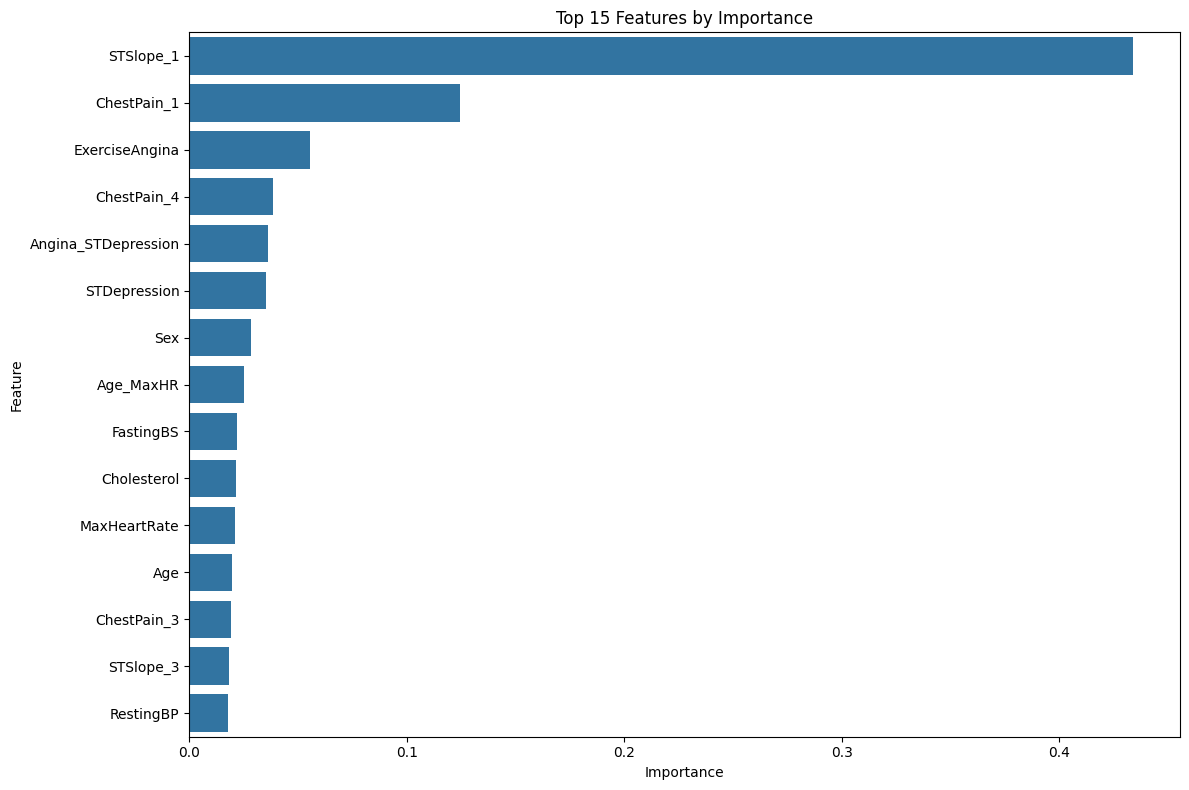

In [60]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()
plt.savefig('feature_importance.png')
plt.close()

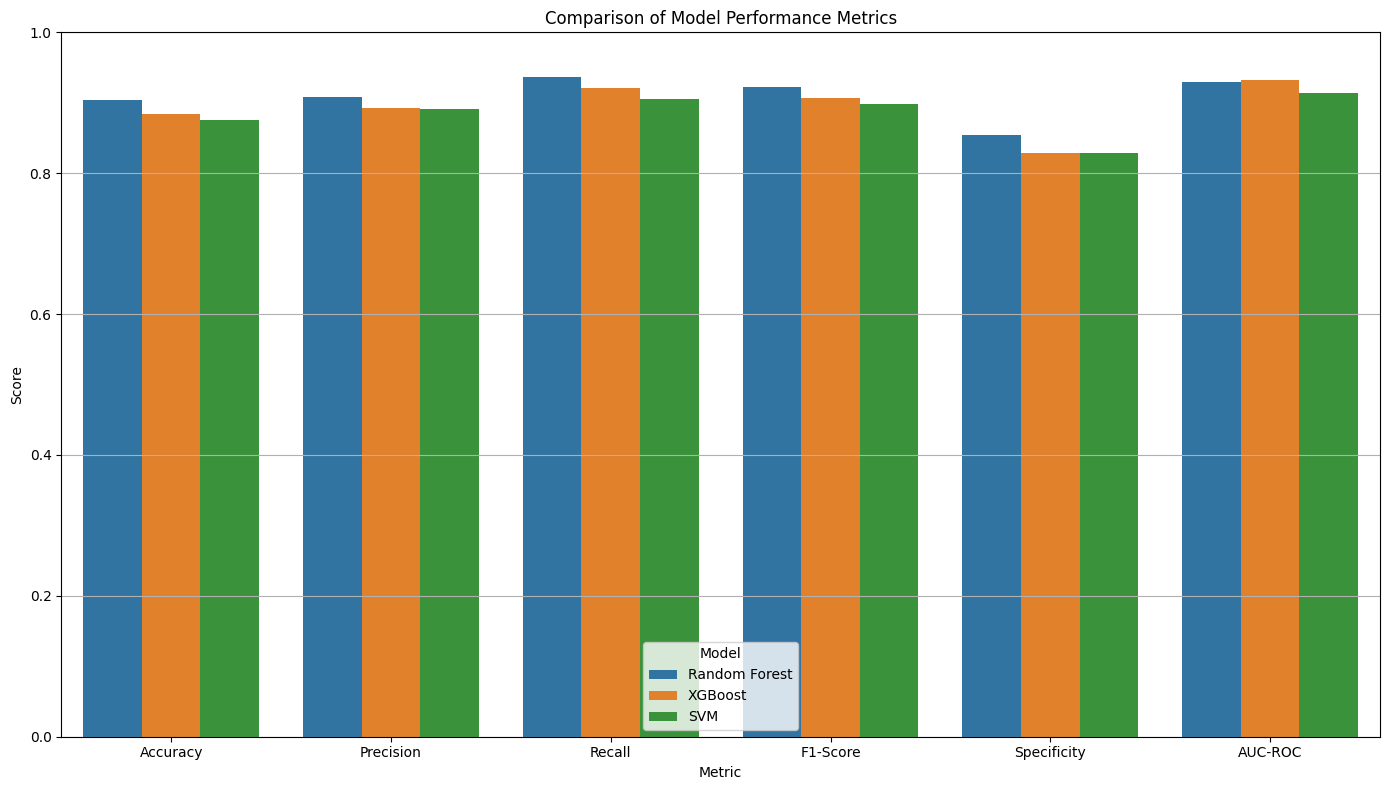

In [61]:
metrics = {}

metrics['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, rf_model.predict(X_test_scaled)),
    'Precision': precision_score(y_test, rf_model.predict(X_test_scaled)),
    'Recall': recall_score(y_test, rf_model.predict(X_test_scaled)),
    'F1-Score': f1_score(y_test, rf_model.predict(X_test_scaled)),
    'Specificity': recall_score(y_test, rf_model.predict(X_test_scaled), pos_label=0),
    'AUC-ROC': roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
}

metrics['XGBoost'] = {
    'Accuracy': accuracy_score(y_test, xgb_model.predict(X_test_scaled)),
    'Precision': precision_score(y_test, xgb_model.predict(X_test_scaled)),
    'Recall': recall_score(y_test, xgb_model.predict(X_test_scaled)),
    'F1-Score': f1_score(y_test, xgb_model.predict(X_test_scaled)),
    'Specificity': recall_score(y_test, xgb_model.predict(X_test_scaled), pos_label=0),
    'AUC-ROC': roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])
}

metrics['SVM'] = {
    'Accuracy': accuracy_score(y_test, svm_model.predict(X_test_scaled)),
    'Precision': precision_score(y_test, svm_model.predict(X_test_scaled)),
    'Recall': recall_score(y_test, svm_model.predict(X_test_scaled)),
    'F1-Score': f1_score(y_test, svm_model.predict(X_test_scaled)),
    'Specificity': recall_score(y_test, svm_model.predict(X_test_scaled), pos_label=0),
    'AUC-ROC': roc_auc_score(y_test, svm_model.predict_proba(X_test_scaled)[:, 1])
}

metrics_df = pd.DataFrame.from_dict(metrics, orient='index').reset_index()
metrics_df = metrics_df.rename(columns={'index': 'Model'})

metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_melted)
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

plt.savefig('model_performance_comparison.png')
plt.close()

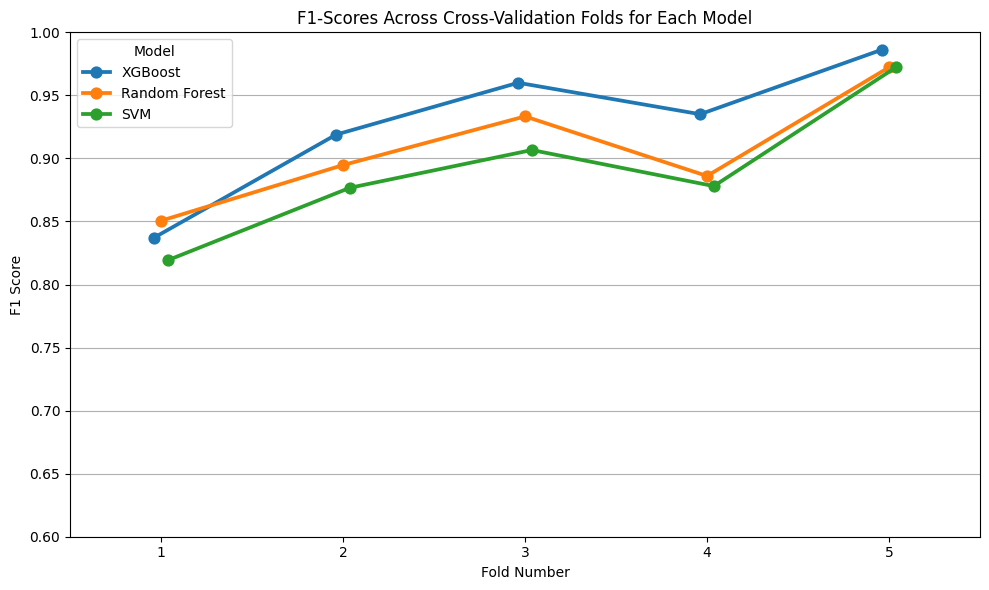

In [62]:
f1_scores_xgb = cross_val_score(xgb_model, X_train_resampled_scaled, y_train_resampled, cv=5, scoring='f1', n_jobs=-1)
f1_scores_rf = cross_val_score(rf_model, X_train_resampled_scaled, y_train_resampled, cv=5, scoring='f1')
f1_scores_svm = cross_val_score(svm_model, X_train_resampled_scaled, y_train_resampled, cv=5, scoring='f1')

folds = range(1, 6)

f1_df = pd.DataFrame({
    'Fold': np.tile(folds, 3),
    'F1 Score': np.concatenate([f1_scores_xgb, f1_scores_rf, f1_scores_svm]),
    'Model': ['XGBoost'] * 5 + ['Random Forest'] * 5 + ['SVM'] * 5
})

mean_f1 = f1_df.groupby('Model')['F1 Score'].mean().reset_index()
std_f1 = f1_df.groupby('Model')['F1 Score'].std().reset_index()
mean_f1 = mean_f1.rename(columns={'F1 Score': 'Mean F1'})
std_f1 = std_f1.rename(columns={'F1 Score': 'Std F1'})
summary_f1 = pd.merge(mean_f1, std_f1, on='Model')

plt.figure(figsize=(10, 6))
sns.pointplot(data=f1_df, x='Fold', y='F1 Score', hue='Model', dodge=True)

plt.title('F1-Scores Across Cross-Validation Folds for Each Model')
plt.xlabel('Fold Number')
plt.ylabel('F1 Score')
plt.ylim(0.6, 1.0)
plt.grid(axis='y')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('f1_scores.png')
plt.show()
plt.close()

In [63]:
joblib.dump(xgb_model, 'xgb_model.joblib')
joblib.dump(rf_model, 'rf_model.joblib')
joblib.dump(svm_model, 'svm_model.joblib')

joblib.dump(scaler, 'scaler.joblib')
joblib.dump(X_train_resampled_scaled.columns.tolist(), 'feature_list.joblib')

joblib.dump(numerical_features, 'training_numerical_features.joblib')


print("Models, scaler, and feature list saved successfully.")

Models, scaler, and feature list saved successfully.


In [64]:
import joblib


joblib.dump(X_train.columns.tolist(), 'feature_list.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(numerical_features, 'training_numerical_features.joblib')

['training_numerical_features.joblib']

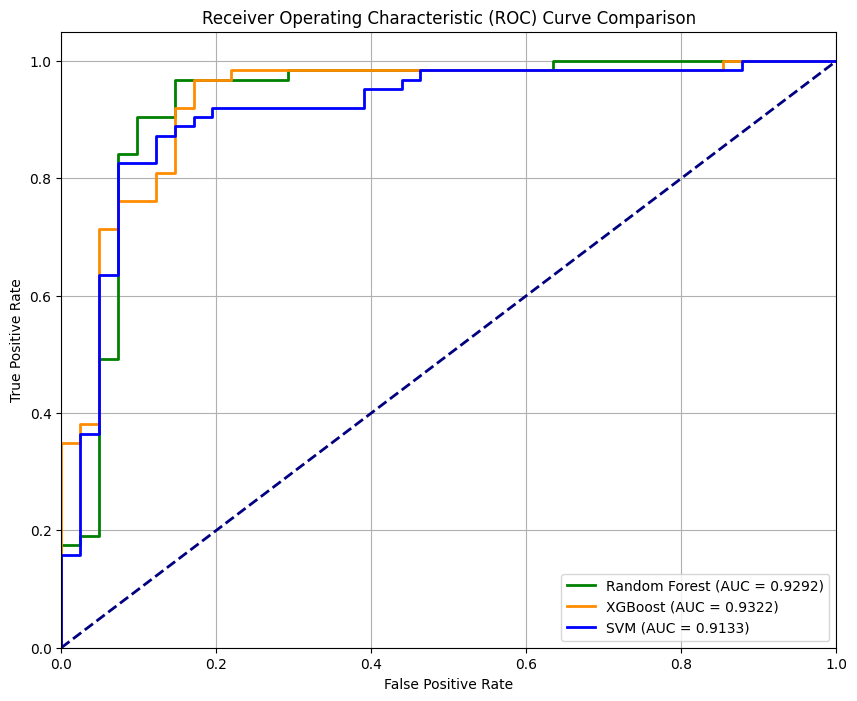

In [65]:
from sklearn.metrics import roc_curve, auc

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.savefig('roc_curve_comparison.png')
plt.close()

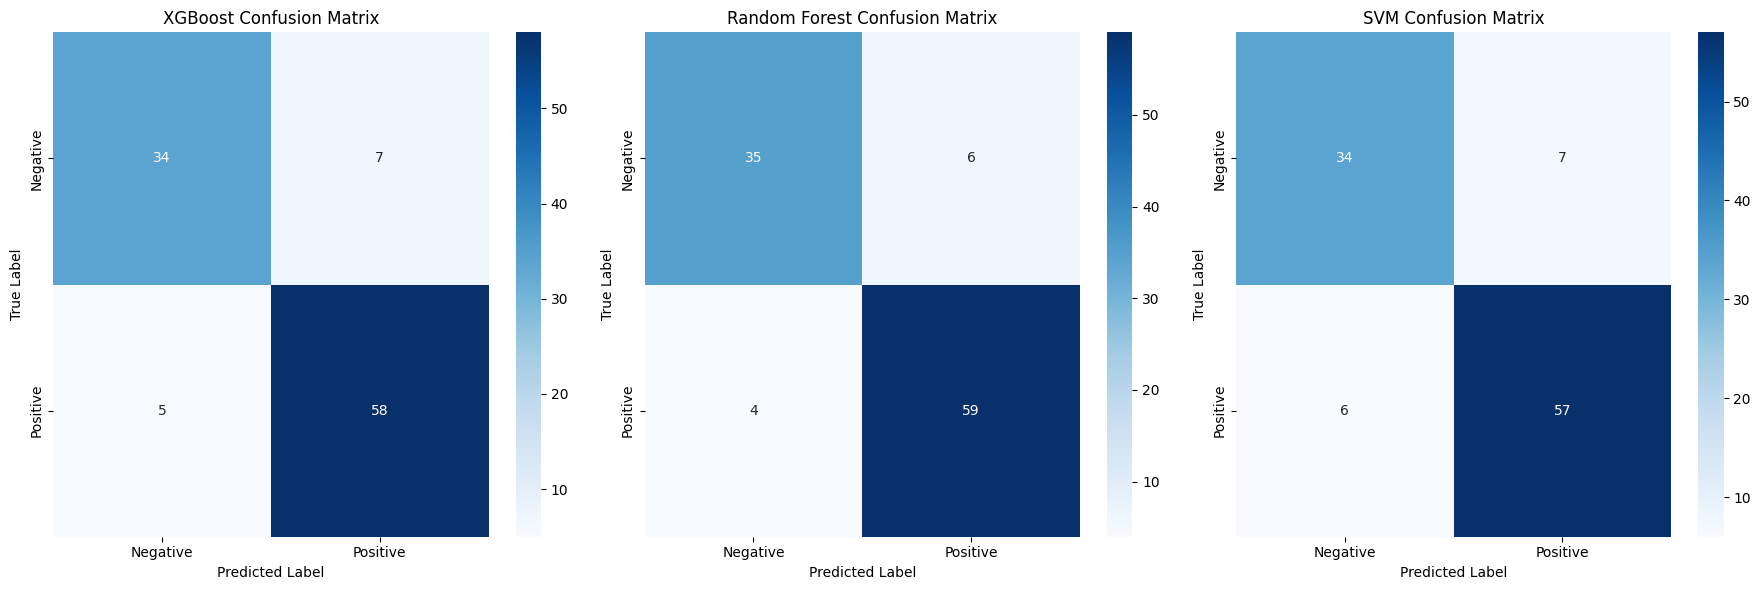

In [66]:
cm_xgb = confusion_matrix(y_test, xgb_model.predict(X_test_scaled))
cm_rf = confusion_matrix(y_test, rf_model.predict(X_test_scaled))
cm_svm = confusion_matrix(y_test, svm_model.predict(X_test_scaled))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('XGBoost Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(['Negative', 'Positive'])
axes[0].set_yticklabels(['Negative', 'Positive'])

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(['Negative', 'Positive'])
axes[1].set_yticklabels(['Negative', 'Positive'])

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('SVM Confusion Matrix')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_xticklabels(['Negative', 'Positive'])
axes[2].set_yticklabels(['Negative', 'Positive'])

plt.tight_layout()
plt.show()

plt.savefig('confusion_matrices.png')
plt.close()